In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import sys
import time

import matplotlib

# for interactive plots in Jupyter:
# matplotlib.use('qtagg')

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

Good Finish Dates for PHYS mc16_13TeV: `2022-05-28`, `2022-11-19`

Good Finish Dates for Higgs mc16_13TeV: `2021-10-27`, `2022-11-24`

Good Finish Dates for Mixed (higgs+topq+susy+phys): `2023-03-21`, `2023-04-06`

In [2]:
# finish_date = pd.Timestamp('2021-10-27')
# horizon_date = finish_date + pd.Timedelta('7 days')

span_threshold = pd.Timedelta('90 days')
history_len = pd.Timedelta('365 days')

accesses_threshold = 30


source_csv = (
    '/home/mshubin/Desktop/datasets-popularity-task-data/' +
    # 'datasets_popularity_DAOD_mixed_' + 
    # 'higgd-topq-susy-phys_mc16_13TeV_202308141254.csv'
    'datasets_popularity_DAOD_HIGGD_mc16_13TeV_202309211655.csv'
    # 'datasets_popularity_DAOD_PHYS_mc16_13TeV_202308141254.csv'
)

In [3]:
df = pd.read_csv(source_csv)

df['datetime'] = pd.to_datetime(df['datetime'])

len(df)

1474809

In [4]:
bar1 = tqdm(total=len(df))

def base_datasetname(ds_name):
    idx = ds_name.rfind('_tid')
    if idx == -1:
        raise RuntimeError('Dataset name without a TID')
    bar1.update()
    return ds_name[:idx]

df['base_datasetname'] = df['datasetname'].apply(base_datasetname)
bar1.close()

100%|████████████████████████████| 1474809/1474809 [00:01<00:00, 1316551.46it/s]


In [5]:
n_sub_datasets = df.groupby(['base_datasetname'])['datasetname'].nunique()

In [6]:
history = df[df['datetime'] <= finish_date]

target_period = df[(df['datetime'] > finish_date) &
                   (df['datetime'] <= horizon_date)]

history_gb = history.groupby(['base_datasetname'])
target_period_gb = target_period.groupby(['base_datasetname'])

n_accesses = history_gb['datetime'].count()
access_dates = history_gb['datetime'].apply(lambda x : x.to_numpy())
n_users = history_gb['username'].nunique()
n_access_days = history_gb['datetime'].nunique()
last_date = history_gb['datetime'].max()

future_popularity = target_period_gb['datetime'].count()

objs_df = pd.DataFrame(
    {
        'n_accesses' : n_accesses,
        'access_dates' : access_dates,
        'n_users' : n_users,
        'n_access_days' : n_access_days,
        'last_date' : last_date
    }
)

objs_df['y'] = 0
objs_df['n_sub_datasets'] = 0

print('filling \'y\' column')    
for ds_name, ds_features in tqdm(objs_df.iterrows(), total=len(objs_df)):
    if ds_name in future_popularity:
        objs_df.loc[ds_name, 'y'] = future_popularity[ds_name]
    objs_df.loc[ds_name, 'n_sub_datasets'] = n_sub_datasets[ds_name]

filling 'y' column


100%|███████████████████████████████████| 77396/77396 [00:14<00:00, 5523.32it/s]


In [7]:
objs_df = objs_df[objs_df['n_accesses'] > accesses_threshold]
len(objs_df), len(objs_df[objs_df['y'] > 0])

(7452, 1743)

In [8]:
objs_df['has_history'] = False

ds_histories = {}

for ds_name, ds_features in tqdm(objs_df.iterrows(), total=len(objs_df)):
    arr = ds_features['access_dates']
    arr.sort()
    latest_start = finish_date - history_len + pd.Timedelta('1 day')
    possible_starts = arr[arr <= latest_start]

    # at first, try to use history starting with an access
    for i in range(len(possible_starts) - 1, -1, -1): 
        start = possible_starts[i]
        finish = start + history_len - pd.Timedelta('1 day')
        arr2 = arr[(arr >= start) & (arr <= finish)]
        if arr2[-1] - arr2[0] >= span_threshold:
            objs_df.loc[ds_name, 'has_history'] = True
            ds_histories[ds_name] = (start, arr2)
            break
    else: # if not found, try to use the last interval
        start = latest_start
        finish = finish_date
        arr2 = arr[(arr >= start) & (arr <= finish)]
        if len(arr2) and (arr2[-1] - arr2[0] >= span_threshold):
            objs_df.loc[ds_name, 'has_history'] = True
            ds_histories[ds_name] = (start, arr2)

objs_df = objs_df[objs_df['has_history']]
objs_df['history'] = ds_histories

100%|█████████████████████████████████████| 7452/7452 [00:06<00:00, 1099.50it/s]


In [9]:
len(objs_df), len(objs_df[objs_df['y'] > 0])

(7328, 1715)

In [10]:
bar = tqdm(total=len(objs_df))

def dates_array_to_timeseries(arg):
    start, history_dates = arg
    finish = start + history_len - pd.Timedelta('1 day')
    res = pd.Series(0,
                    index=pd.date_range(start, finish, freq='D'),
                    dtype=np.dtype('int32'))

    for d in history_dates:
        res[d] += 1

    bar.update()
    return res.to_numpy()

objs_df['history_ts'] = objs_df['history'].apply(dates_array_to_timeseries)
bar.close()

100%|██████████████████████████████████████| 7328/7328 [00:11<00:00, 622.49it/s]


In [11]:
# Custom colormap for forthcoming HeatMap
# Blue-to-Red, but with White zeros

newcolors = np.zeros((256, 4))
for i in range(newcolors.shape[0]):
    newcolors[i] = [i / 255, 0.0, (newcolors.shape[0] - i - 1) / 255, 1.0]
newcolors[0] = [1.0, 1.0, 1.0, 1.0]
newcm = ListedColormap(newcolors)

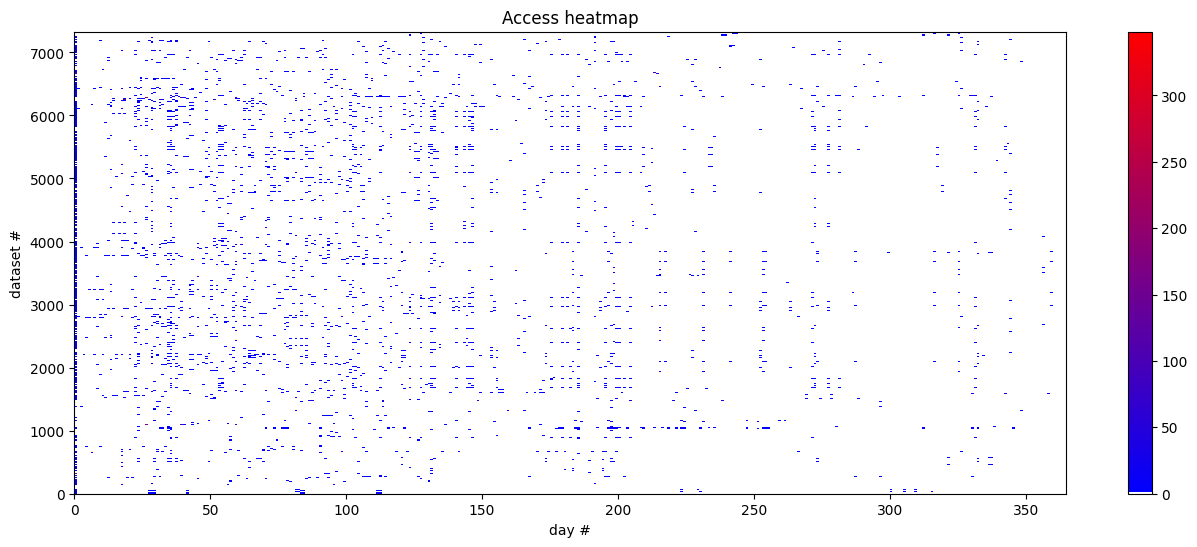

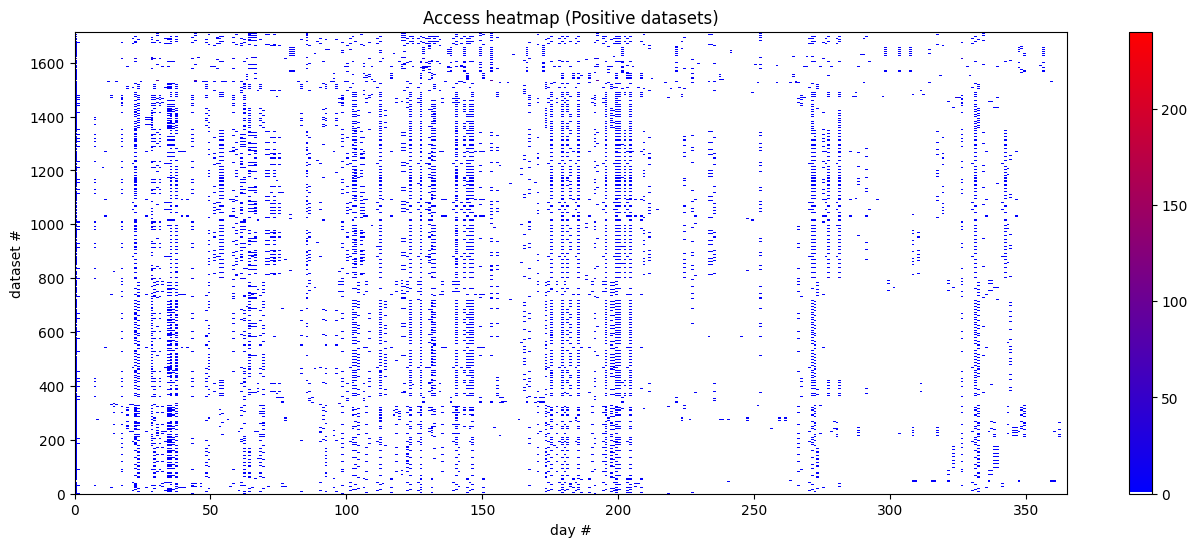

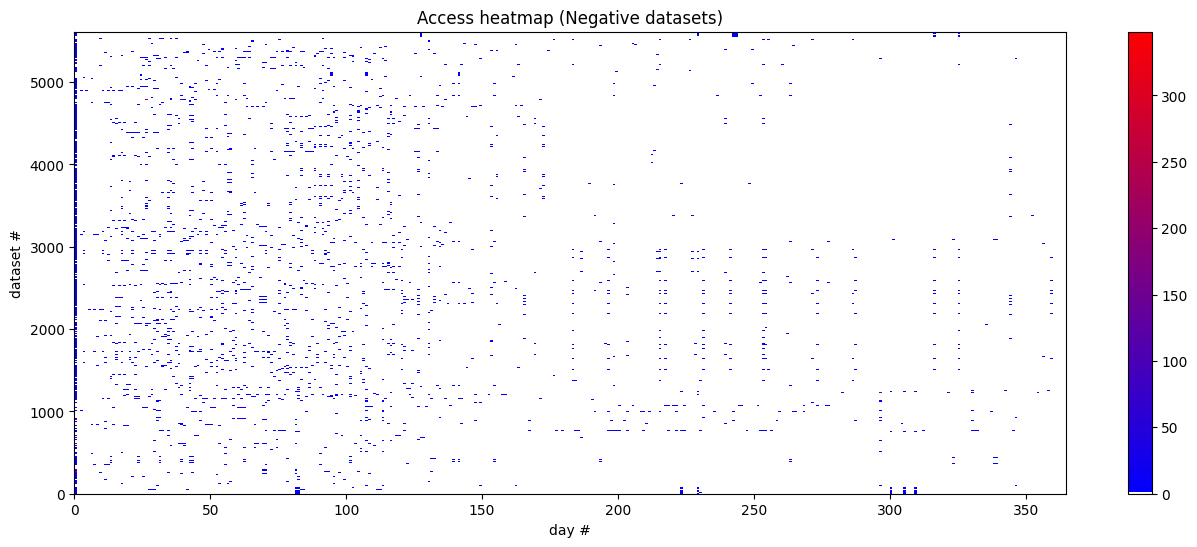

In [12]:
heat_matrix = np.stack(objs_df['history_ts'].to_numpy())

fig, ax = plt.subplots()
fig.set(figwidth=16, figheight=6)
ax.set(xlabel='day #', ylabel='dataset #',
       title='Access heatmap')


psm = ax.pcolormesh(heat_matrix, cmap=newcm, rasterized=True)
fig.colorbar(psm, ax=ax)

# plt.show() # for interactive backend

heat_matrix = np.stack(objs_df[objs_df['y'] > 0]['history_ts'].to_numpy())

fig, ax = plt.subplots()
fig.set(figwidth=16, figheight=6)
ax.set(xlabel='day #', ylabel='dataset #',
       title='Access heatmap (Positive datasets)')


psm = ax.pcolormesh(heat_matrix, cmap=newcm, rasterized=True)
fig.colorbar(psm, ax=ax)

# plt.show() # for interactive backend

heat_matrix = np.stack(objs_df[objs_df['y'] == 0]['history_ts'].to_numpy())

fig, ax = plt.subplots()
fig.set(figwidth=16, figheight=6)
ax.set(xlabel='day #', ylabel='dataset #',
       title='Access heatmap (Negative datasets)')


psm = ax.pcolormesh(heat_matrix, cmap=newcm, rasterized=True)
fig.colorbar(psm, ax=ax)

# plt.show() # for interactive backend

In [14]:
print(*objs_df['n_sub_datasets'].to_numpy())

2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 3 1 3 3 1 3 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 3 1 1 1 1 2 2 2 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 2 2 2 1 2 2 1 2 2 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 1 1 1 1 1 1 2 2 2 1 2 1 2 1 1 1 1 1 2 2 2 1 1 2 2 1 1 2 2 1 1 2 2 1 1 2 2 2 1 1 2 2 1 1 2 2 3 2 1 2 2 2 3 3 1 1 1 1 1 2 2 2 2 2 3 3 1 1 1 1 2 2 2 1 2 2 3 1 

merging datasets with different tids


100%|████████████████████████████| 1474809/1474809 [00:01<00:00, 1338706.21it/s]


filling 'y' and 'n_sub_datasets' columns


100%|███████████████████████████████████| 90574/90574 [00:16<00:00, 5405.70it/s]


after filtering by access number: 1761 / 10055
filtering by history presence


100%|███████████████████████████████████| 10055/10055 [00:08<00:00, 1194.14it/s]


after filtering: 1754 / 9881
transforming date arrays to timeseries


100%|██████████████████████████████████████| 9881/9881 [00:13<00:00, 740.56it/s]


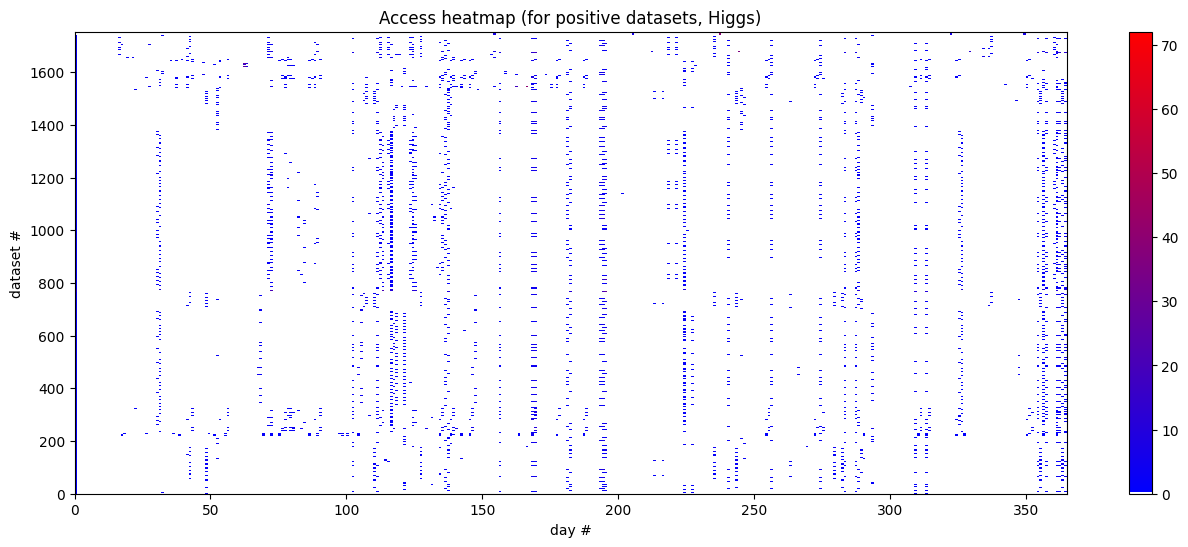

In [15]:
from transform_filter_data import transform_filter_data
from visualize_heatmap_accesses import plot_heatmap_accesses
import numpy as np

o_df_2 = transform_filter_data(
    source_csv = source_csv,
    finish_date = pd.Timestamp('2022-11-24'),
    horizon_date = pd.Timestamp('2022-11-24') + pd.Timedelta('7 days'),
    span_threshold = span_threshold,
    history_len = history_len,
    accesses_threshold = accesses_threshold,
    merge_tids = True
)

plot_heatmap_accesses(
    np.stack(o_df_2[o_df_2['y'] > 0]['history_ts'].to_numpy()),
    title='Access heatmap (for positive datasets, Higgs)'
)

filling 'y' column


100%|██████████████████████████████████| 26726/26726 [00:00<00:00, 30356.44it/s]


after filtering by access number: 118 / 4053
filtering by history presence


100%|█████████████████████████████████████| 4053/4053 [00:01<00:00, 2580.80it/s]


after filtering: 118 / 3117
transforming date arrays to timeseries


100%|██████████████████████████████████████| 3117/3117 [00:06<00:00, 517.65it/s]


merging datasets with different tids


100%|██████████████████████████████| 441296/441296 [00:00<00:00, 1574953.61it/s]


filling 'y' and 'n_sub_datasets' columns


100%|███████████████████████████████████| 15889/15889 [00:02<00:00, 7201.82it/s]


after filtering by access number: 105 / 3254
filtering by history presence


100%|█████████████████████████████████████| 3254/3254 [00:01<00:00, 1811.40it/s]


after filtering: 66 / 2195
transforming date arrays to timeseries


100%|██████████████████████████████████████| 2195/2195 [00:07<00:00, 287.95it/s]


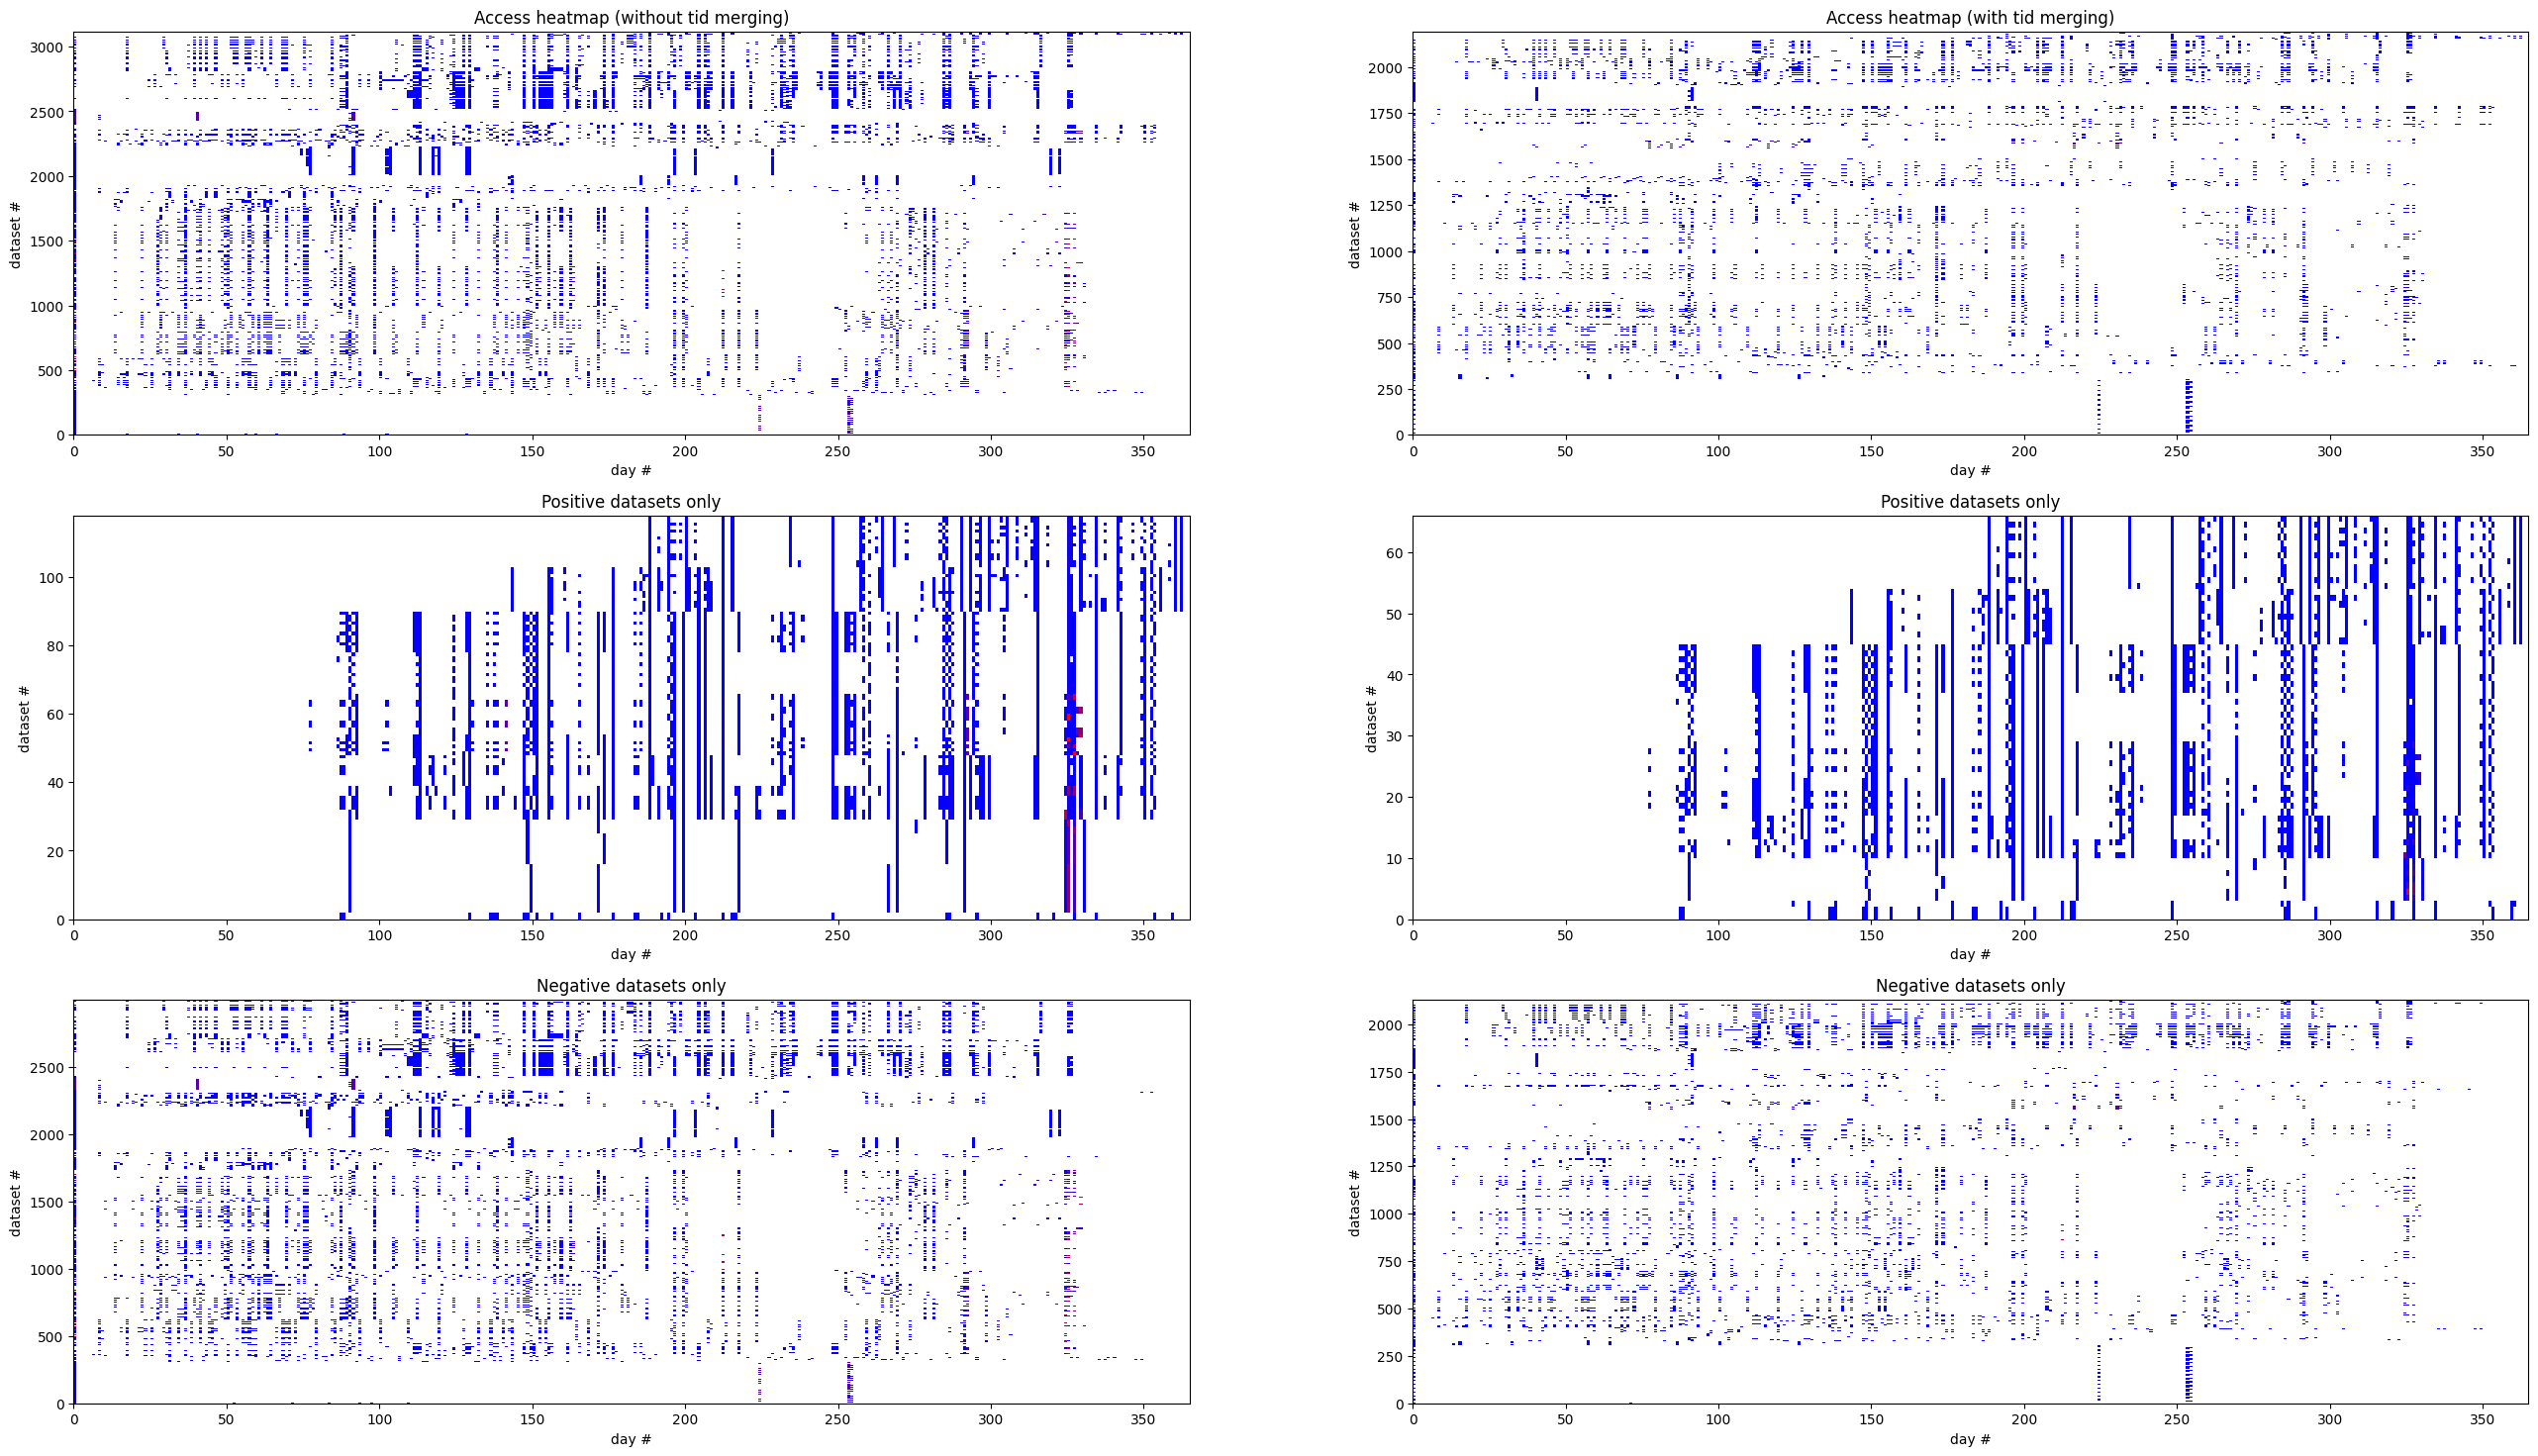

In [1]:
from transform_filter_data import transform_filter_data
from visualize_heatmap_accesses import plot_comparison
import numpy as np

df1 = transform_filter_data()
df2 = transform_filter_data(merge_tids=True)

plot_comparison(df1, df2)

In [5]:
# fname = 'filtering-without-with-tid-merge-comparison.png'
# plot_comparison(df1, df2, savefig_path=fname)